<h3><b>Introduction</b></h3>
<p> The goal of this project is to take the publically available Beijing weather data from 2013 to 2017 and apply machine learning techniques to see if we can predict the amount of PM2.5 concentration in the air given other environmental features. This is a project I am working on during my free time applying some of the machine learning algorithms I have learned. I hope to come up with a predictive model with a high accuracy and a very low Root Mean Square Error (RMSE).</p>
<br>
<h5><b>Dataset Information</b></h5>
<p>This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. Missing data are denoted as NA.</p>
<br>
<h5><b>Project workflow</b></h5>
<p>This project utilizes the Supervised Machine Learning algorithms from python’s Scikit-learn library. The model we hope to succeed in training is a regression model and below are the steps we will go through in this jupyter notebook for this project:</p>
<ul>
    <li>Import the neccessary libraries and loading the data</li>
    <li>Data preprocessing</li>
    <li>Exploratory Data Ananlysis</li>
    <li>Model training and Evaluation</li>
    <li>Saving the model</li>
</ul>
<br>
<h5><b>Import libraries and loading data</b></h5>

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.externals import joblib
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display

In [140]:
# get the name of the csv file 
#file = 'https://raw.githubusercontent.com/prince381/air-pollution/master/data/PRSA_Data_Aotizhongxin_20130301-20170228.csv' 
file = r'C:\Users\DELL\Desktop\EDUCATE\DATA CSV\PRSA_Data_20130301-20170228\data\PRSA_Data_Aotizhongxin_20130301-20170228.csv'

# read the csv file into a pandas DataFrame using the pd.read_csv()
data = pd.read_csv(file)
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


<h3><b>Data Preprocessing</b></h3>

In [141]:
# drop the unwanted columns/features
cols_to_drop = ['No','station']
data = data.drop(cols_to_drop,axis=1)
# print out the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 16 columns):
year     35064 non-null int64
month    35064 non-null int64
day      35064 non-null int64
hour     35064 non-null int64
PM2.5    34139 non-null float64
PM10     34346 non-null float64
SO2      34129 non-null float64
NO2      34041 non-null float64
CO       33288 non-null float64
O3       33345 non-null float64
TEMP     35044 non-null float64
PRES     35044 non-null float64
DEWP     35044 non-null float64
RAIN     35044 non-null float64
wd       34983 non-null object
WSPM     35050 non-null float64
dtypes: float64(11), int64(4), object(1)
memory usage: 4.3+ MB


In [142]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


year        0
month       0
day         0
hour        0
PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
PRES       20
DEWP       20
RAIN       20
wd         81
WSPM       14
dtype: int64

In [143]:
# find the most appearing wind direction value
data.wd.mode()

0    NE
dtype: object

In [144]:
# fill in the missing values with the mean of the particular column
data.fillna(value=data.mean(),inplace=True)
# replace the missing values for the wind direction with the modal value
data.wd.fillna(value='NE',inplace=True)
# let's check the data again if there are any missing values
data.isnull().any()

year     False
month    False
day      False
hour     False
PM2.5    False
PM10     False
SO2      False
NO2      False
CO       False
O3       False
TEMP     False
PRES     False
DEWP     False
RAIN     False
wd       False
WSPM     False
dtype: bool

In [145]:
# create a datetime column using the year,month,day and hour columns.
years = data['year'].values
months = data['month'].values
days = data['day'].values
hours = data['hour'].values
full_date = []

for i in range(data.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
data = pd.concat([dates,data],axis=1)

data.head()

,date,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


<h3><b>Exploratory Data Analysis</b></h3>
<p>Before we start fitting a machine learning model on the data, we need to know much about the data by performing an Exploratory Data Analysis to gain insight from it. <abbr title="Exploratory Data Analysis">EDA</abbr> is simply describing the data by means of visualization. It involves asking questions about the data and answering them with the help of charts/graphs (graphical representation of the data). In this process, we will try to study the behavoir of the amount of pollutant (PM2.5 concentration) in the air and the relationship between other features. Below are some of the questions we will try to answer by analyzing the data, to know more about our dependent and independent variables:</p>
<ul>
    <li>what pattern does the amount of PM2.5 concentration in the air recorded in an hour follow
        for a daily time period ?</li>
    <li>In which month does the amount of PM2.5 contained in the air rises ?</li>
    <li>At what time of the day do we expect the amount of PM2.5 concentration in the
        air to be high ?</li>
    <li>In which direction does polluted air/wind mostly move ?</li>
    <li>How do the other environmental factors affect the amount of PM2.5 concentration
        in the air ?</li>
</ul>
<p>We now have our questions so let's just dive into our data and start finding and interpreting some results. But since we are going to take averages of the dependent variable, we shoul know the distribtution of the data before we do take averages.</p>

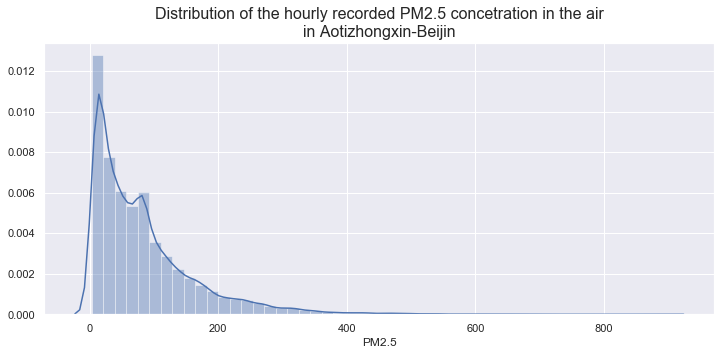

In [146]:
plt.figure(figsize=(12,5))
sns.distplot(data['PM2.5'],bins=50)
plt.title('Distribution of the hourly recorded PM2.5 concetration in the air\nin Aotizhongxin-Beijin',
          fontsize=16)
plt.show()

<h5><b>what pattern does the amount of PM2.5 concentration in the air recorded in an hour follow
        for a daily time period ?</b></h5>

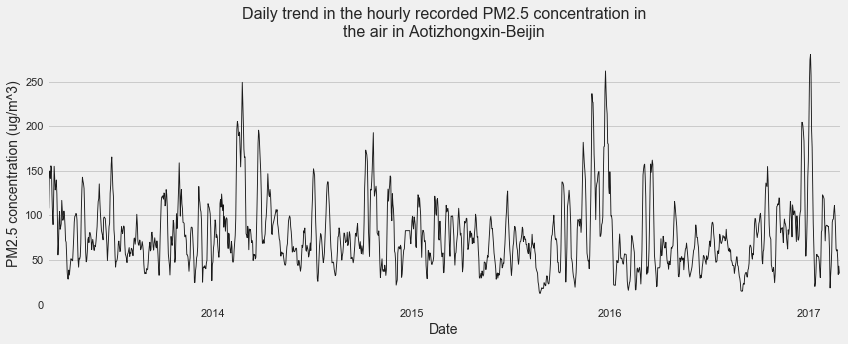

In [147]:
# find the daily average of PM2.5 contained in the air in any given hour
daily_data = data[['date','PM2.5']]
daily_data = daily_data.set_index('date')
daily_data = daily_data.resample('D').median()
decomposition = seasonal_decompose(daily_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(12,5),style='k-',linewidth=.9,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Daily trend in the hourly recorded PM2.5 concentration in\nthe air in Aotizhongxin-Beijin',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>In which month does the amount of PM2.5 contained in the air rises ?</b></h5>

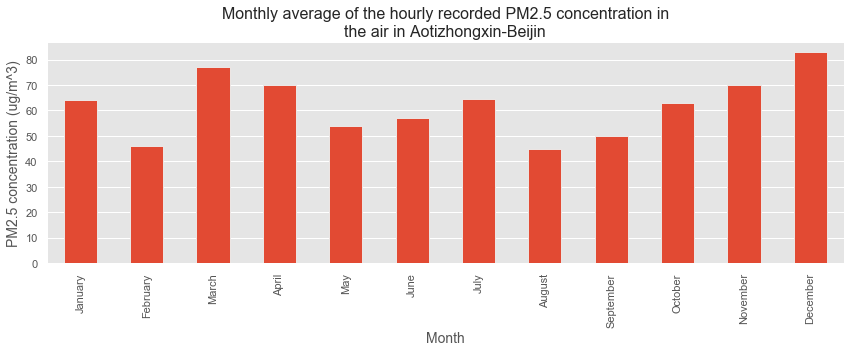

In [148]:
monthly_data = data[['month','PM2.5']]
months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(months,columns=['month'])
map_dict = {}
for i,j in enumerate(months):
    map_dict.setdefault(i+1,j)

monthly_data.month = monthly_data.month.map(map_dict)
monthly_average = monthly_data.groupby('month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM2.5 concentration in\nthe air in Aotizhongxin-Beijin',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>At what time of the day do we expect the amount of PM2.5 concentration in the air to be high ?</b></h5>

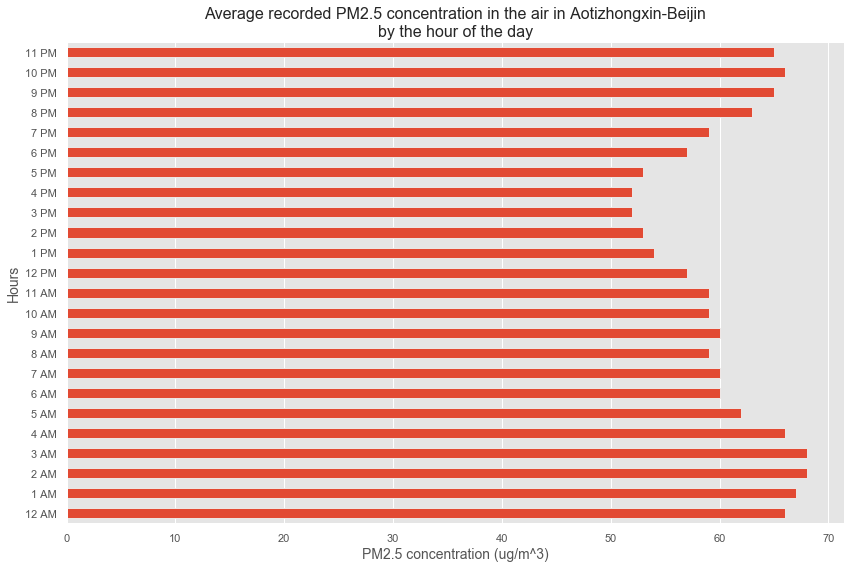

In [149]:
hourly_data = data[['hour','PM2.5']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)
    
hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data.hour = hourly_data.hour.map(hour_dict)
hourly_data = hourly_data.set_index('hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12,8),legend=False,kind='barh',linewidth=.9)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM2.5 concentration in the air in Aotizhongxin-Beijin\nby the hour of the day',fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

<h5><b>In which direction does polluted air/wind mostly move ?</b></h5>

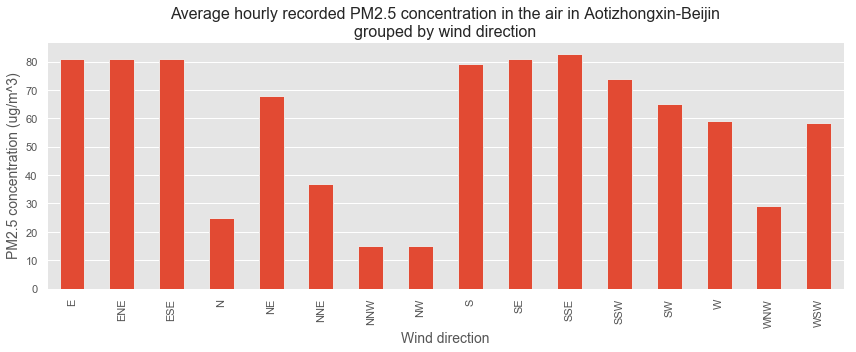

In [150]:
wind_dir = data[['wd','PM2.5']]
wind_dir = wind_dir.groupby('wd').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM2.5 concentration in the air in Aotizhongxin-Beijin\ngrouped by wind direction',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>How do the other environmental factors affect the amount of PM2.5 concentration in the air ?</b></h5>

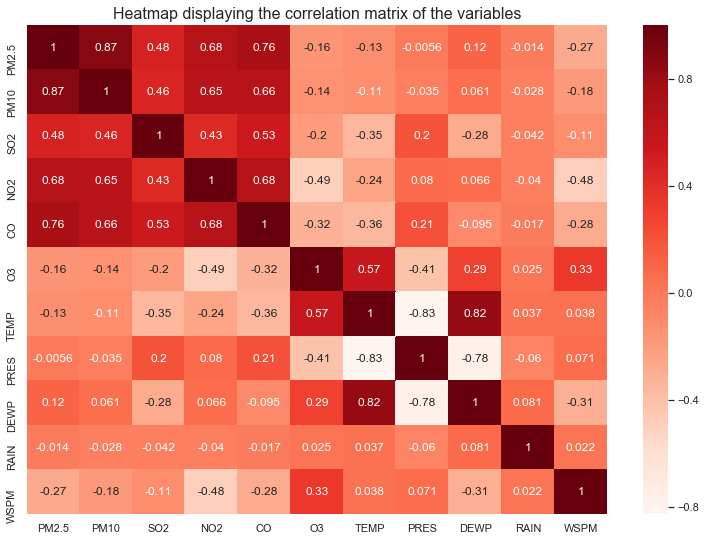

In [151]:
# let's try and visualize the relationships between the features of the data
plt.figure(figsize=(13,9))
correlation_data = data[['PM2.5', 'PM10', 'SO2', 'NO2',
                         'CO', 'O3', 'TEMP', 'PRES',
                         'DEWP', 'RAIN', 'WSPM']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

<h3><b>Model Training and Evaluation</b></h3>
<br>
<h5><b>check for multicollinearity among variables and fit a regression model using statsmodels</b></h5>

In [152]:
cols_to_drop = ['date','year','month','day','hour','wd']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const    35340.419725
PM2.5        6.350322
PM10         4.811566
SO2          1.670510
NO2          3.320432
CO           3.159039
O3           2.250103
TEMP         8.214959
PRES         3.667310
DEWP         6.517281
RAIN         1.023639
WSPM         1.788731
dtype: float64

In [153]:
# we can see that TEMP (temperature) and DEWP (dewpoint) are highly correlated as the VIF value is 
# greater than 5. As a result, we get rid of one of those features and probably the one that has the 
# lowest correlation with the dependent variable.
newdata = newdata.drop('DEWP',axis=1)
cons_data2 = sm.tools.add_constant(newdata)
series_after = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after

const    33490.920665
PM2.5        5.972024
PM10         4.704558
SO2          1.560019
NO2          3.314615
CO           3.133916
O3           2.168322
TEMP         4.559340
PRES         3.463731
RAIN         1.009170
WSPM         1.460474
dtype: float64

In [154]:
newdata.columns = ['PM2_5','PM10','SO2','NO2','CO','O3','TEMP','PRES','RAIN','WSPM']

# PM2.5 is skewed to the right so we log transform the values to normalize the distribution
newdata['PM2_5'] = np.log(newdata['PM2_5'])

In [155]:
# fit the regression model
mul_reg = formula.ols(formula='PM2_5 ~ PM10 + SO2 + NO2 + CO + O3 + TEMP + PRES + RAIN + WSPM',
                      data=newdata).fit()
mul_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2_5   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     9636.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:28:20   Log-Likelihood:                -30906.
No. Observations:               35064   AIC:                         6.183e+04
Df Residuals:                   35054   BIC:                         6.192e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5181      0.571      9.668      0.000       4.399       6.637
PM10           0.0056   5.11e-05    109.188      0.000       0.005       0.006
SO2            0.0040      0.000     23.039      0.000       0.004       0.004
NO2            0.0060      0.000     39.113      0.000       0.006       0.006
CO             0.0002    4.2e-06     40.083      0.000       0.000       0.000
O3             0.0021    8.1e-05     25.491      0.000       0.002       0.002
TEMP           0.0110      0.001     18.899      0.000       0.010       0.012
PRES          -0.0028      0.001     -5.102      0.000      -0.004      -0.002
RAIN           0.0237      0.003      6.888      0.000       0.017       0.030
WSPM          -0.1399      0.003    -45.047      0.000      -0.146      -0.134
==============================================================================
Omnibus:                     3697.836   Durbin-Watson:                   0.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5978.516
Skew:                          -0.761   Prob(JB):                         0.00
Kurtosis:                       4.333   Cond. No.                     3.50e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<p>The OLS model from statsmodels gives us an accuracy of 71% (0.712) which is not satisfactory for prediction. So we move on to fit a linear regression model from the scikit-learn library.</p>
<br>
<h5><b>fitting a linear regression model with sklearn.linear_model.LinearRegression()</b></h5>

In [156]:
# we split the data into predictor variables and Outcome variable
X = newdata.drop('PM2_5',axis=1)
y = newdata['PM2_5']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,RAIN,WSPM
0,-1.125409,-0.594053,-1.430285,-0.809141,0.365570,-1.253510,1.072316,-0.074107,2.235814
1,-1.082965,-0.594053,-1.430285,-0.809141,0.365570,-1.288611,1.091545,-0.074107,2.485022
2,-1.093576,-0.549641,-1.348251,-0.809141,0.294746,-1.288611,1.120388,-0.074107,3.232647
3,-1.104187,-0.283168,-1.320906,-0.809141,0.277040,-1.314937,1.216533,-0.074107,1.155913
4,-1.136020,-0.238756,-1.293562,-0.809141,0.277040,-1.367589,1.283835,-0.074107,0.242150


In [157]:
# we now split out data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.2,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)   # fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [158]:
# we now score the model
print('Score on train data: {}\n'.format(lin_model.score(X_train,y_train)))
print('Score on test data: {}'.format(lin_model.score(X_test,y_test)))

Score on train data: 0.7116905619118638

Score on test data: 0.7138206964831479


In [159]:
prediction = lin_model.predict(X_test)
mse = mean_squared_error(y_test,prediction)
accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Overall model accuracy: {}'.format(accuracy))

Mean Squared Error: 0.3384419958089878

Overall model accuracy: 0.7138206964831479


<p>The model accuracy for the LinearRegression() is no better than that of the statsmodels. They all give the same accuracy is not better for making predictions. We now move on to fit other models by using the ensemble methods</p>
<br>
<br>
<h3><b>Ensemble methods</b></h3>
<p>For ensemble methods (DecisionTreeRegressor,RandomForestRegressor,and GradientBoostingRegressor),we include the pressure and rain features and we won't scale the predictor variables,neither would we log transform the outcome variable. At this part, model fitting and hyper-parameter tunning will be done at the same time. Instead of fitting the model with single parameters, we will straight away perform the grid search with multiple values for a parameter and find the best parameters for fitting the model on our data to get a satisfactory accuracy.</p>

In [160]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('PM2.5',axis=1)
y = ensemble_data['PM2.5']

In [161]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

### DecisionTreeRegressor
we will now fit a decision tree regression model on the data and tune some of its parameters to increase the accuracy.

In [175]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [177]:
# we now score the model
print('Score on train data: {}\n'.format(decision_tree.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(decision_tree.score(xtest,ytest)))

tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.8726415765577269

Score on test data: 0.8585663434593064

Root Mean Squared Error: 30.249022611467236

Overall model accuracy: 0.8585663434593064


In [178]:
# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                 

In [179]:
# we now score the model
print('Score on train data: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(tree_search.score(xtest,ytest)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Score on train data: 0.9028652194161406

Score on test data: 0.888680893391384

Best parameters found:


{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 2}

Root Mean Squared Error: 26.83612572970069

Overall model accuracy: 0.8886808933913839


### RandomForestRegressor

we now fit a random forest regression model on the data to see if we would get a better accuracy results than that of the decision tree regression model.

In [180]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [181]:
# we now score the model
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.9149654135707646

Score on test data: 0.9045468853679719

Root Mean Squared Error: 24.850207175331573

Overall model accuracy: 0.9045468853679719


In [182]:
# we now tune the parameters of the RandomForestRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [183]:
# we now score the model
print('Score on train data: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest_search.score(xtest,ytest)))
print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Score on train data: 0.8988326176595388

Score on test data: 0.8995933109458588

Best parameters found:


{'n_estimators': 500,
 'min_samples_split': 8,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 7}

Root Mean Squared Error: 25.486857158527293

Overall model accuracy: 0.8995933109458589


### GradientBoostingRegressor

we now fit a gradient boosting regression model on the data to see if we would get a better accuracy results than that of the decision tree and random forest regression model and also minimize the error.

In [184]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [185]:
# we now score the model
print('Score on train data: {}\n'.format(grad_boost.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(grad_boost.score(xtest,ytest)))

gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.9629363030230438

Score on test data: 0.9343132063362775

Root Mean Squared Error: 20.614556387477222

Overall model accuracy: 0.9343132063362775


In [186]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [187]:
# we now score the model
print('Score on train data: {}\n'.format(gboost_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(gboost_search.score(xtest,ytest)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.9537995646052737

Score on test data: 0.9304405766853177

Best parameters found:


{'n_estimators': 400,
 'min_samples_split': 9,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 5,
 'learning_rate': 0.1}

Root Mean Squared Error: 21.213530276613525

Overall model accuracy: 0.9304405766853177


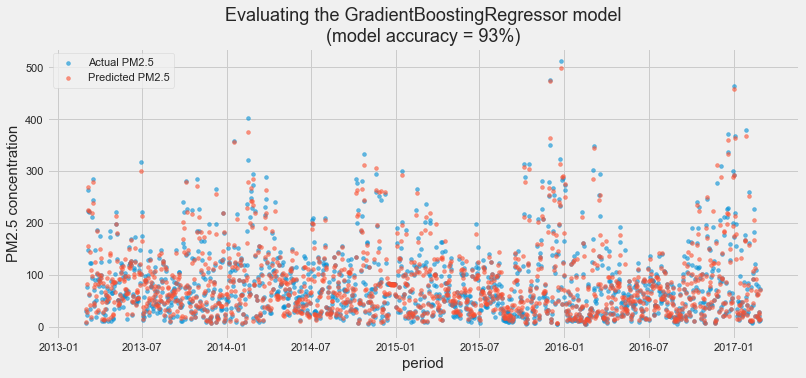

In [189]:
# we now use the best model (GradientBoostingRegressor model) to predict the PM2.5 
# concetration and compare it to the actual PM2.5 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':gboost_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the GradientBoostingRegressor model\n(model accuracy = 93%)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()

<h5><b>Residuals analysis</b></h5>
<p>Now that we have successfully trained a regression model that predicts the amount of PM2.5 concetration in the air with a 93% accuracy given other environmental features, we have to analyze the errors of prediction to see if the model satisfies the regression errors asumption. That is,the errors must be normally distributed and do not follow any pattern.</p>

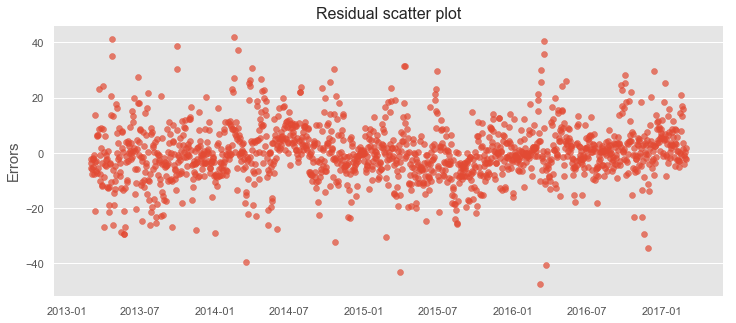

In [197]:
# calculate the errors
compare_data['Residuals'] = compare_data['Actual PM2.5'] - compare_data['Predicted PM2.5']

# make a scatter plot of the errors to see if they follow any pattern
with plt.style.context('ggplot'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data.Residuals,alpha=.7)
    plt.title('Residual scatter plot',fontsize=16)
    plt.ylabel('Errors',fontsize=15)
    plt.grid(axis='x')
    plt.show()

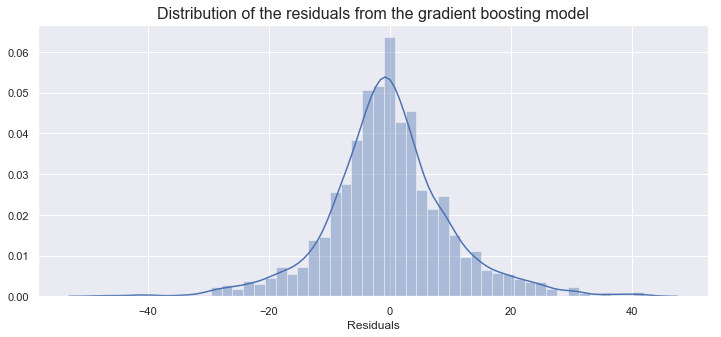

In [198]:
# plot the histogram to see check the normality of the errors
plt.figure(figsize=(12,5))
sns.distplot(compare_data.Residuals,bins=50)
plt.title('Distribution of the residuals from the gradient boosting model',
         fontsize=16)
plt.show()

<p>As seen above, the residuals of the predictions follow no pattern and also have a normal distribution which satisfies the regression error assumptions. This proves that our model is accurate and good for further predictions.</p>
<br>
<h3><b>Saving and loading the model</b></h3>
<p>Now that the model has been successfully trained, the next thing is to save and be able to load it anytime we want to use it. To do this, we have to save it as a pickle file using the joblib module from sklearn.externals. The cells below shows you how to save your trained machine learning model and also load it anytime you want.</p>

In [199]:
from sklearn.externals import joblib

In [ ]:
# save the model to my desktop
joblib.dump(gboost_search,'.\\Desktop\\pm25_model.pkl')

In [ ]:
# loading the model
regression_model = joblib.load('.\\Desktop\\pm25_model.pkl')

<br>
<br>
<br>
<h4><b>Project completed by: Prince Owusu</b></h4>
<p><a href="mailto:powusu381@gmail.com" target="_blank">Email</a> || <a href="https://www.linkedin.com/in/prince-owusu-356914198?lipi=urn%3Ali%3Apage%3Ad_flagship3_profile_view_base_contact_details%3B2NYoXqMHQKOMp0yWSME5mQ%3D%3D" target="_blank">LinkedIn</a> || <a href="https://twitter.com/iam_kwekhu" target="_blank">Twitter</a></p>